# AutoRegressive Integrated Moving Average (ARIMA)

ARIMA (p, d, q) is a widely used statistical method for time series forecasting. It is particularly effective for datasets that exhibit trends and patterns over time, under the assumption that these patterns are linear and consistent. ARIMA is primarily applied to univariate time series data, such as stock prices, demand forecasting, or weather trends.

The method integrates three key components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). Below is a brief overview of each component and their roles in the forecasting process:

1. ___AutoRegressive (AR) Component (_p_)___
The AR part of the model represents a regression of the variable on its own lagged (previous) values. It captures the relationship between the current value and its past values.
<br><br>

2. ___Integrated (I) Component (_d_)___
The I component represents differencing of the time series to make it stationary, which means the statistical properties of the series (mean, variance, autocorrelation) are constant over time.
<br><br>

3. ___Moving Average (MA) Component (_q_)___
The MA part models the relationship between the current observation and past forecast errors. It smooths out noise by considering the errors in previous periods.

### 01. Import libraries

In [29]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import itertools
from math import sqrt

# Graph
import plotly.graph_objs as go
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data source
import yfinance as yf

# Create features (datetime)
from fastai.tabular.core import add_datepart

In [30]:
# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

### 02. Import data

__yfinance__ is a Python library that simplifies access and manipulation of financial data, allowing users to easily interact with historical and current stock market data. Here are the main reasons to use it:

In [90]:
# Download historical data for a stock
ticker = 'EURUSD=X'
df = yf.download(tickers=ticker, period='10y', interval='1d')

# Move the index to a column
df = df.reset_index()

# Drop the MultiIndex level (keep the first level only)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

# Replace blank space in the name of the columns
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.head()

[*********************100%***********************]  1 of 1 completed


Price,date,close,high,low,open,volume
0,2015-01-02,1.208941,1.208956,1.201080,1.208868,0
1,2015-01-05,1.194643,1.197590,1.188909,1.195500,0
2,2015-01-06,1.193902,1.197000,1.188693,1.193830,0
3,2015-01-07,1.187536,1.190000,1.180401,1.187479,0
4,2015-01-08,1.183600,1.184806,1.175601,1.183894,0


In [91]:
# Declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Live share price evolution',
    yaxis_title='Stock Price (USD per Shares)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=3, label="3h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show
fig.show()

### 03. Feature engineering

Feature engineering involves transforming, creating, and selecting the most relevant features from the original data to enhance the accuracy and efficiency of predictive models.

In this case, extensive feature engineering is less critical since the model focuses exclusively on the 'close' column.

In [92]:
# Create a column for the previous day's close
df['prev_close'] = df.shift(1)['close']

# Calculate the daily change in the closing price
df['close_change'] = df.apply(
    lambda row: 0 if np.isnan(row.prev_close) else (row.close - row.prev_close), 
    axis=1
)

# Remove the temporary prev_close column
df.drop('prev_close', axis=1, inplace=True)

# Calculate the return
df['return'] = (df['close']-df['open'])/df['open']

df.head()

Price,date,close,high,low,open,volume,close_change,return
0,2015-01-02,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060
1,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,-0.014298,-0.000717
2,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060
3,2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.006366,0.000047
4,2015-01-08,1.183600,1.184806,1.175601,1.183894,0,-0.003936,-0.000249


In [93]:
# Ensure the 'date' column is the index
df = df.set_index('date')

# Make the DataFrame have daily frequency (including weekends)
df = df.asfreq('D')

# Forward fill missing data (weekends will be filled with the previous available data)
df = df.ffill(downcast='infer')

# Sort by date to ensure it's in chronological order
df = df.sort_index()

# Reset the index if you want to move 'date' back to a column
df = df.reset_index()

df.head()

Price,date,close,high,low,open,volume,close_change,return
0,2015-01-02,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060
1,2015-01-03,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060
2,2015-01-04,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060
3,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,-0.014298,-0.000717
4,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060


In [94]:
# Specify the lag features for which rolling statistics will be calculated
lag_features = ["high", "low", "volume"]

# Define rolling window sizes
window1 = 3
window2 = 7
window3 = 30

# Calculate rolling windows for each feature with specified sizes
df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

# Calculate the rolling means for each window and shift by 1 to avoid data leakage
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

# Calculate the rolling standard deviations for each window and shift by 1 to avoid data leakage
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

# Add new features for mean and standard deviation for each lag feature and window size
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

# Fill any remaining NaN values with the column-wise mean to ensure a clean dataset
df.fillna(df.mean(), inplace=True)

df.head()

Price,date,close,high,low,open,volume,close_change,return,high_mean_lag3,high_mean_lag7,...,low_mean_lag30,low_std_lag3,low_std_lag7,low_std_lag30,volume_mean_lag3,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30
0,2015-01-02,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060,1.122709,1.122799,...,1.115945,0.002463,0.004241,0.008775,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-03,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060,1.208956,1.208956,...,1.201080,0.002463,0.004241,0.008775,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-04,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060,1.208956,1.208956,...,1.201080,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,-0.014298,-0.000717,1.208956,1.208956,...,1.201080,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060,1.205168,1.206115,...,1.198037,0.007027,0.006085,0.006085,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# Save data in other variable, then make it a index
df['date_temp'] = df['date']

# Add date parts
df = add_datepart(df, 'date')
df.drop('Elapsed', axis=1, inplace=True)
df['mon_fri'] = ((df['Dayofweek'] == 0) | (df['Dayofweek'] == 4)).astype(int)

# Replace blank space in the name of the columns
df.columns = df.columns.str.lower().str.replace(' ','_')

# Convert all boolean columns to 1 and 0
boolean_columns = ['is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start'] 
df[boolean_columns] = df[boolean_columns].astype(int)

# # Set 'date' column as the index
df.set_index('date_temp', inplace=True)

df.head()

Price,close,high,low,open,volume,close_change,return,high_mean_lag3,high_mean_lag7,high_mean_lag30,...,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,mon_fri
date_temp,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060,1.122709,1.122799,1.123258,...,2,4,2,0,0,0,0,0,0,1
2015-01-03,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060,1.208956,1.208956,1.208956,...,3,5,3,0,0,0,0,0,0,0
2015-01-04,1.208941,1.208956,1.201080,1.208868,0,0.000000,0.000060,1.208956,1.208956,1.208956,...,4,6,4,0,0,0,0,0,0,0
2015-01-05,1.194643,1.197590,1.188909,1.195500,0,-0.014298,-0.000717,1.208956,1.208956,1.208956,...,5,0,5,0,0,0,0,0,0,1
2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060,1.205168,1.206115,1.206115,...,6,1,6,0,0,0,0,0,0,0


### 04. Pre-processing

Unlike other machine learning models, in the case of time series, __it is crucial to ensure that partitions are performed respecting the temporal order of the data__, avoiding random mixing of the data.

In [96]:
# Split into training and testing
train_size = int(len(df) * 0.90)
df_train, df_test = df[:train_size], df[train_size:]

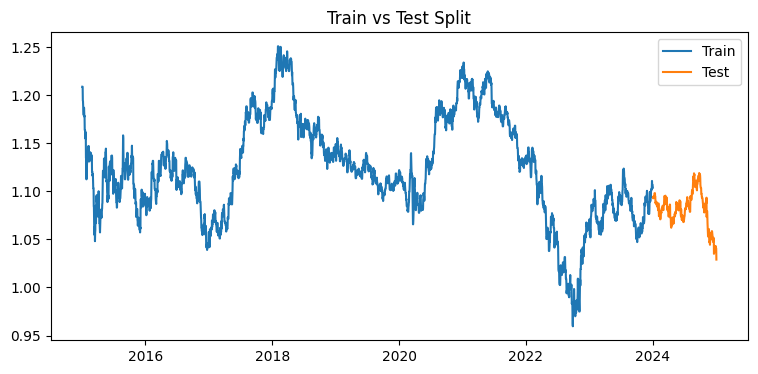

In [97]:
# Visualización del conjunto Train y Test
plt.figure(figsize=(9, 4))
plt.plot(df_train.close, label="Train")
plt.plot(df_test.close, label="Test")
plt.title("Train vs Test Split")
plt.legend()
plt.show()

### 05. Modeling

In this step, the ARIMA(p, d, q) model is configured by determining its three components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). Below is a breakdown of each component and how it is calculated:

- ___p (AutoRegressive):___ Determined by identifying the highest significant lag in the Autocorrelation Function (ACF) plot.
- ___d (Integrated):___ Represents the order of differencing required to make the time series stationary. Typically, this value is 1 or 2 if differencing is necessary.
- ___q (Moving Average):___ Based on the number of significant lags observed in the Partial Autocorrelation Function (PACF) plot.

#### 05.1 Option 1:

In this approach, differencing ___d(I)___ is applied first to make the time series stationary before calculating the values for ___𝑝 (AR)___ and ___𝑞 (MA)___.

This is the traditional method; however, it may result in overly simplistic or flat predictions.

___Estimate d (Integrated)___

In [98]:
# Differencing to Estimate 'd' (Integrated Component)
def stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

In [99]:
# Function to check stationarity
def test_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return p_value

# Function to identify how many differencing steps are needed
def find_differencing_order(series):
    d = 0
    p_value = test_stationarity(series)
    
    # While the series is not stationary (p-value > 0.05), apply differencing
    while p_value > 0.05:
        series = series.diff().dropna()  # Difference the series
        d += 1
        p_value = test_stationarity(series)
        print(f"Differencing step {d}: p-value = {p_value}")
    
    return d

___Estimate p (AutoRegressive) y q (Moving Average)___

In [100]:
def estimate_p_q(series, max_lags=20):
    """
    Automatically estimates the p and q orders for an ARIMA model using ACF and PACF.
    
    Parameters:
    - series: pd.Series, the input time series.
    - max_lags: int, the maximum number of lags to consider in the ACF and PACF plots.
    
    Returns:
    - p: order of the AR (AutoRegressive) component.
    - q: order of the MA (Moving Average) component.
    """
    # Calculating ACF and PACF
    acf_vals, confint_acf = acf(series, nlags=max_lags, alpha=0.05)
    pacf_vals, confint_pacf = pacf(series, nlags=max_lags, alpha=0.05)
    
    # Create a 1x2 subplot layout
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    plot_acf(series, lags=max_lags, ax=ax[0])
    ax[0].set_title("ACF (Estimate q)")
    plot_pacf(series, lags=max_lags, ax=ax[1])
    ax[1].set_title("PACF (Estimate p)")
    plt.tight_layout()
    plt.show()


    # Identify the first lag where ACF and PACF cross the significance limit
    q = next(i for i, val in enumerate(acf_vals[1:], 1) if abs(val) < confint_acf[i][1])  # first lag where ACF crosses upper limit
    p = next(i for i, val in enumerate(pacf_vals[1:], 1) if abs(val) < confint_pacf[i][1])  # first lag where PACF crosses upper limit
    
    print(f"Estimated p (AR): {p}")
    print(f"Estimated q (MA): {q}")
    
    return p, q

___Find the order (p, d, q) and predict___

In [101]:
# Check stationarity of the original series
print("Original Series Stationarity Test:")
stationarity(df_train.close)

Original Series Stationarity Test:
ADF Statistic: -2.5013259392010023
p-value: 0.11515204267546769
Critical Values:
    1%: -3.4323458605158654
    5%: -2.8624218526902547
    10%: -2.567239428686678
The series is not stationary.


In [102]:
# Check number of estimate 'd'
d_order = find_differencing_order(df_train.close)

print(f"{d_order} differencing step(s) are needed to make the series stationary.")

Differencing step 1: p-value = 0.0
1 differencing step(s) are needed to make the series stationary.


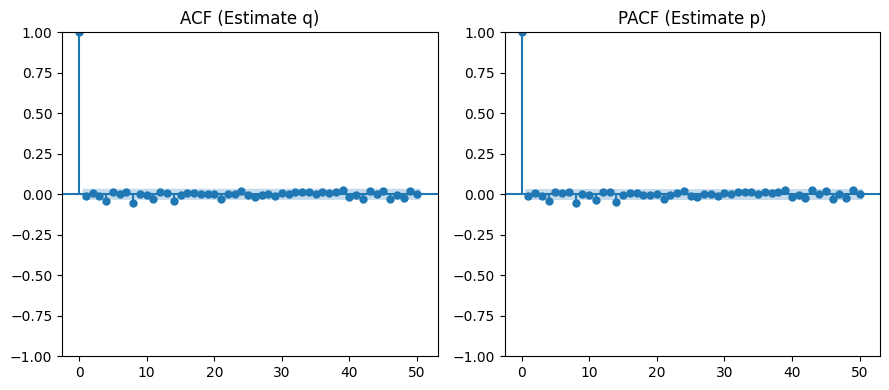

Estimated p (AR): 1
Estimated q (MA): 1


In [103]:
# Apply differencing to make the series stationary
df_train_diff = df_train.close.diff(d_order).dropna()

# Estimate p and q
p_order, q_order = estimate_p_q(df_train_diff, max_lags=50)

In [104]:
# # Manual Estimation
# d_order = 1 # The number of differencing steps needed to make the series stationary.
# p_order = 1 # Determined by the PACF; corresponds to the lag with the highest significant value, followed by the second-highest.
# q_order = 8 # Determined by the ACF; represents the first lag outside the confidence interval (blue shadow).

___Build model, test and predict___

In [105]:
# Fit ARIMA model
arima_model = ARIMA(df_train.close, order=(p_order, d_order, q_order))
fitted_arima_model = arima_model.fit()

# Print model summary
print(fitted_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3288
Model:                 ARIMA(1, 1, 1)   Log Likelihood               12902.054
Date:                Thu, 02 Jan 2025   AIC                         -25798.108
Time:                        10:31:42   BIC                         -25779.815
Sample:                    01-02-2015   HQIC                        -25791.559
                         - 01-02-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -2.391e-09      0.007  -3.36e-07      1.000      -0.014       0.014
ma.L1      -2.393e-09      0.007  -3.37e-07      1.000      -0.014       0.014
sigma2      2.277e-05   3.13e-07     72.858      0.0

In [106]:
# Make predictions on the test data
# predictions = fitted_arima_model.forecast(steps=len(df_test.close))
predictions = fitted_arima_model.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Calculate performance metrics
def evaluate_model_performance(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
    
    return mse, mae, r2

# Evaluate model performance on test data
mse, mae, r2 = evaluate_model_performance(df_test.close, predictions)

Mean Squared Error: 0.0008043408451730658
Mean Absolute Error: 0.023784286343770323
R-squared: -1.4906721115565595


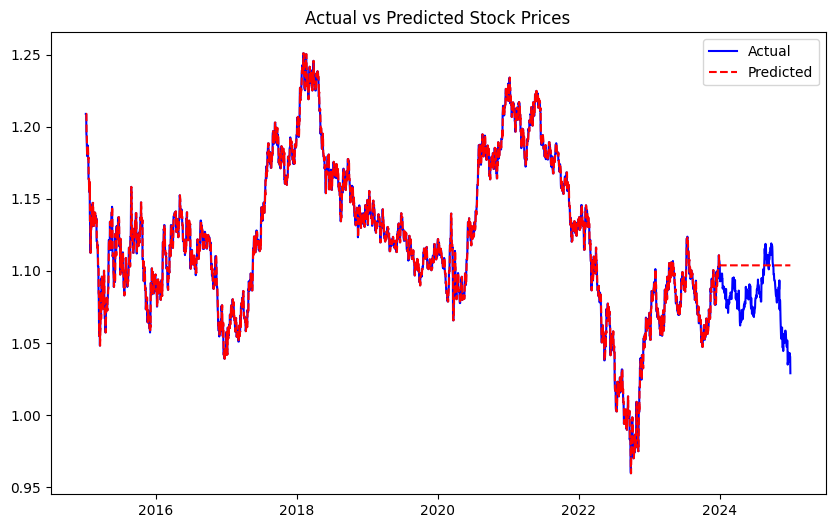

In [117]:
# Make predictions for the entire dataset (both train and test)
predictions = fitted_arima_model.predict(start=df.index[1], end=df.index[-1], dynamic=False)

# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': df['close'],  # Replace 'close' with the column you're predicting
    'Predicted': predictions
})

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test data
predictions = fitted_arima_model.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Create a trace for training data
trace1 = go.Scatter(
    x=df_train.index,
    y=df_train.close,
    mode='lines',
    name='Training Data'
)

# Create a trace for test data
trace2 = go.Scatter(
    x=df_test.index,
    y=df_test.close,
    mode='lines',
    name='Test Data'
)

# Create a trace for predicted values
trace3 = go.Scatter(
    x=predictions.index,
    y=predictions.values,
    mode='lines',
    name='Predictions'
)

# Combine all traces in a list
data_x = [trace1, trace2, trace3]

# Create a layout
layout = go.Layout(
    title='Actual vs. Predicted Values',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price')
)

# Create a figure
fig = go.Figure(data=data_x, layout=layout)


# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()

In [107]:
# Make predictions on the test data
predictions = fitted_arima_model.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Make predictions on the test data
predictions = fitted_arima_model.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Create a trace for training data
trace1 = go.Scatter(
    x=df_train.index,
    y=df_train.close,
    mode='lines',
    name='Training Data'
)

# Create a trace for test data
trace2 = go.Scatter(
    x=df_test.index,
    y=df_test.close,
    mode='lines',
    name='Test Data'
)

# Create a trace for predicted values
trace3 = go.Scatter(
    x=predictions.index,
    y=predictions.values,
    mode='lines',
    name='Predictions'
)

# Combine all traces in a list
data_x = [trace1, trace2, trace3]

# Create a layout
layout = go.Layout(
    title='Actual vs. Predicted Values',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price')
)

# Create a figure
fig = go.Figure(data=data_x, layout=layout)


# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()a

In [108]:
# Make predictions to 10 day more
predictions = fitted_arima_model.predict(start=df_test.index[-1], end=df_test.index[-1] + pd.Timedelta(10, freq='D'), steps=10, dynamic=False)

# Create a trace for training data
trace1 = go.Scatter(
    x=df_train.index,
    y=df_train.close,
    mode='lines',
    name='Training Data'
)

# Create a trace for test data
trace2 = go.Scatter(
    x=df_test.index,
    y=df_test.close,
    mode='lines',
    name='Test Data'
)

# Create a trace for predicted values
trace3 = go.Scatter(
    x=predictions.index,
    y=predictions.values,
    mode='lines',
    name='Predictions'
)

# Combine all traces in a list
data_x = [trace1, trace2, trace3]

# Create a layout
layout = go.Layout(
    title='Actual vs. Predicted Values',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price')
)

# Create a figure
fig = go.Figure(data=data_x, layout=layout)


# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()

#### 05.2 Option 2:

In this approach, auto_arima automatically determines the optimal values for the differencing (d), autoregressive (p), and moving average (q) terms based on model selection criteria like AIC, BIC, etc. This removes the need for manual specification of these values.

In [ ]:
# Apply auto_arima to automatically select the best p, d, q values
model_auto_arima = auto_arima(df_train.close, seasonal=False, trace=True, 
                              stepwise=True, suppress_warnings=True)

# Fit the model
fitted_model_auto_arima = model_auto_arima.fit(df_train.close)

# Print model summary
print(fitted_model.summary())

In [ ]:
# Make predictions
forecast_steps = 10  # specify the number of periods to forecast
forecast = model_auto_arima.predict(n_periods=forecast_steps)

In [ ]:
model_autoARIMA = auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=50, max_q=50, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()



#Modeling
# Build Model
model = ARIMA(df_train, order=(1,1,1))  
fitted = model.fit()  
print(fitted.summary())


fc, se, conf = fitted.forecast(321, alpha=0.05)[:3]


# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
# lower_series = pd.Series(conf[:, 0], index=df_test.index)
# upper_series = pd.Series(conf[:, 1], index=df_test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train, label='training data')
plt.plot(df_test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 05.3 Option 3:

In this approach, the ARIMA model is manually tuned by using the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to determine the appropriate lag values for the Moving Average (q) and AutoRegressive (p) components. Here's how it works:

Differencing is still considered, but ACF and PACF are used to identify the optimal values of ___𝑝___ and ___q___ directly from the data before applying the differencing step. The order of differencing is determined by the ADF test, which checks for stationarity.

This could lead to different prediction behaviors compared to using a simpler forecast method, as it incorporates a more complex understanding of the time series structure (including trends and seasonality).

In [111]:
def get_arima_price(df, fact, forecast_steps):
    
    #MA Lags
    acf_coef = acf(df[fact], alpha=.05)
    sig_acf = []
    for i in range(1, len(acf_coef[0])):
        if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
            sig_acf.append(i)
        elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
            sig_acf.append(i)

    #AR Lags
    pacf_coef = pacf(df[fact], alpha=.05)
    sig_pacf = []
    for i in range(1, len(pacf_coef[0])):
        if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
            sig_pacf.append(i)
        elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
            sig_pacf.append(i)

    #Order of integration
    adf = adfuller(x=df[fact], 
                  autolag='BIC')
    order = 0
    if adf[0] < adf[4]['5%']:
        order = 0
    else:
        order = 1

    #Trend indication
    if order == 1:
        trend = 't'
    else:
        trend = 'c'

    #ARIMA(p,d,q) Model
    model = ARIMA(endog = df[fact],
                  order = (sig_pacf, order, sig_acf),
                  trend = trend).fit()
    
    forecast = model.get_forecast(forecast_steps, alpha=0.05)

    predict = model.predict()
    
    return forecast.summary_frame(), model.summary(), predict

In [112]:
forecast, summary_2, predict = get_arima_price(df, 'close', 20)

print(summary_2)

                                    SARIMAX Results                                     
Dep. Variable:                            close   No. Observations:                 3654
Model:             ARIMA([1, 9, 15, 22], 1, 35)   Log Likelihood               14445.081
Date:                          Thu, 02 Jan 2025   AIC                         -28808.162
Time:                                  10:34:53   BIC                         -28553.826
Sample:                              01-02-2015   HQIC                        -28717.590
                                   - 01-02-2025                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -5.29e-05   7.15e-05     -0.740      0.459      -0.000    8.72e-05
ar.L1         -0.0870      0.381     -0.228      0.

In [113]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df.index, y = df['close'], mode = 'lines', name = 'Observed'))
fig.add_trace(go.Scatter(x = predict.index[1:], y = predict[1:], mode = 'lines', name = 'ARIMA Model Prediction'))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean'], mode = 'lines', name = 'ARIMA Model Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_lower'], mode = 'lines', name = 'Forecast Error', line=dict(color='darkblue')))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_upper'], mode = 'lines', line=dict(color='darkblue'), showlegend = False))
#fig.add_trace(go.Scatter(x = [predict.index[-1], forecast.index[0]], y = [predict.iloc[-1], forecast['mean'].iloc[0]], mode = 'lines', name = 'ARIMA Model 1-Day Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index[:4], y = forecast['mean'].iloc[:4], mode = 'lines', name = 'ARIMA Model 4-Day Forecast (Higher Accuracy)'))

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    xaxis_title = 'Days',
    yaxis_title = 'Price $',
    title = f'{ticker} Stock Price'
)

fig.show()

### 06. Model evaluation and interpretation

Assuming the model has already been fine-tuned and trained, we will check its performance on the test set and compare it with the performance obtained on the training and validation sets.

### End

In [ ]:
# Predict with the 20 steps
forecast = fitted_model.get_forecast(steps=len(df_test.close))

# Get predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Step 7: Display the results
forecast_df = pd.DataFrame({
    "Forecast": forecast_mean,
    "Lower Bound": forecast_conf_int.iloc[:, 0],
    "Upper Bound": forecast_conf_int.iloc[:, 1]
})

print("\nForecast for the next 20 steps:")
print(forecast_df)

In [ ]:
# Step 8: Visualize the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train.close, label="Observed", color="blue")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast", color="green")
plt.fill_between(
    forecast_df.index,
    forecast_df["Lower Bound"],
    forecast_df["Upper Bound"],
    color="gray",
    alpha=0.3,
    label="Confidence Interval"
)
plt.title("ARIMA Model Forecast")
plt.legend()
plt.show()

In [ ]:
# Predict with the 20 steps
forecast = fitted_model.get_forecast(steps=len(df_train.close))

# Get predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Step 7: Display the results
forecast_df = pd.DataFrame({
    "Forecast": forecast_mean,
    "Lower Bound": forecast_conf_int.iloc[:, 0],
    "Upper Bound": forecast_conf_int.iloc[:, 1]
})

# Step 8: Visualize the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train.close, label="Observed", color="blue")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast", color="green")
plt.fill_between(
    forecast_df.index,
    forecast_df["Lower Bound"],
    forecast_df["Upper Bound"],
    color="gray",
    alpha=0.3,
    label="Confidence Interval"
)
plt.title("ARIMA Model Forecast")
plt.legend()
plt.show()

In [398]:
# Fit ARIMA model to training data
def fit_arima_model(train_data, p, d, q):
    model = ARIMA(train_data, order=(p, d, q))
    model_fitted = model.fit()
    return model_fitted

# Make forecast on test data
def forecast_arima_model(model_fitted, steps):
    forecast = model_fitted.forecast(steps=steps)
    return forecast

# Calculate performance metrics
def evaluate_model_performance(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
    
    return mse, mae, r2

In [ ]:
# Fit ARIMA model to the training data
model_fitted = fit_arima_model(df_train.close, p_order, d_order, q_order)

# Forecast the test data
forecasted_values = forecast_arima_model(model_fitted, len(df_test))

# Evaluate model performance on test data
mse, mae, r2 = evaluate_model_performance(df_test.close, forecasted_values)

In [ ]:
print(model_fitted.summary())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# Calcular los residuales
residuals = model_fitted.resid

# Graficar los residuales
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuos del Modelo ARIMA')

# Graficar el ACF de los residuales
plt.subplot(122)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos')
plt.show()

# Histograma de los residuales
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histograma de los Residuos')
plt.show()

# Prueba de Ljung-Box para autocorrelación en los residuales
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Prueba de Ljung-Box para autocorrelación (lag=10):")
print(ljung_box_test)

# Prueba de normalidad (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f"Prueba de normalidad Shapiro-Wilk: p-value = {shapiro_test.pvalue}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_test.close, label='Actual', color='blue')
plt.plot(df_test.index, forecasted_values, label='Predicted', color='red')
plt.title("Actual vs Predicted (Test Data)")
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test data
#predictions = model.forecast(steps=len(df_test))
predictions = model_fitted.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Create a trace for training data
trace1 = go.Scatter(
    x=df_train.index,
    y=df_train.close,
    mode='lines',
    name='Training Data'
)

# Create a trace for test data
trace2 = go.Scatter(
    x=df_test.index,
    y=df_test.close,
    mode='lines',
    name='Test Data'
)

# Create a trace for predicted values
trace3 = go.Scatter(
    x=predictions.index,
    y=predictions.values,
    mode='lines',
    name='Predictions'
)

# Combine all traces in a list
data_x = [trace1, trace2, trace3]

# Create a layout
layout = go.Layout(
    title='Actual vs. Predicted Values',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price')
)

# Create a figure
fig = go.Figure(data=data_x, layout=layout)


# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()

In [ ]:
# Column names except 'close' in a variable
exogenous_features = [col for col in df_train.columns if col != 'close']

model = auto_arima(df_train.close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.close, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_test), exogenous=df_test[exogenous_features])
df_test["Forecast_ARIMAX"] = forecast

In [ ]:
df_test[["close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [404]:
def get_arima_price(df, fact, forecast_steps):
    
    #MA Lags
    acf_coef = acf(df[fact], alpha=.05)
    sig_acf = []
    for i in range(1, len(acf_coef[0])):
        if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
            sig_acf.append(i)
        elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
            sig_acf.append(i)

    #AR Lags
    pacf_coef = pacf(df[fact], alpha=.05)
    sig_pacf = []
    for i in range(1, len(pacf_coef[0])):
        if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
            sig_pacf.append(i)
        elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
            sig_pacf.append(i)

    #Order of integration
    adf = adfuller(x=df[fact], 
                  autolag='BIC')
    order = 0
    if adf[0] < adf[4]['5%']:
        order = 0
    else:
        order = 1

    #Trend indication
    if order == 1:
        trend = 't'
    else:
        trend = 'c'

    #ARIMA(p,d,q) Model
    model = ARIMA(endog = df[fact],
                  order = (sig_pacf, order, sig_acf),
                  trend = trend).fit()
    
    forecast = model.get_forecast(forecast_steps, alpha=0.05)

    predict = model.predict()
    
    return forecast.summary_frame(), model.summary(), predict

In [417]:
forecast, summary_2, predict = get_arima_price(df, 'close', 20)

In [ ]:
print(summary_2)

In [ ]:
ticker = 'GOOG'

fig = go.Figure()

fig.add_trace(go.Scatter(x = df.index, y = df['close'], mode = 'lines', name = 'Observed'))
fig.add_trace(go.Scatter(x = predict.index[1:], y = predict[1:], mode = 'lines', name = 'ARIMA Model Prediction'))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean'], mode = 'lines', name = 'ARIMA Model Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_lower'], mode = 'lines', name = 'Forecast Error', line=dict(color='darkblue')))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_upper'], mode = 'lines', line=dict(color='darkblue'), showlegend = False))
#fig.add_trace(go.Scatter(x = [predict.index[-1], forecast.index[0]], y = [predict.iloc[-1], forecast['mean'].iloc[0]], mode = 'lines', name = 'ARIMA Model 1-Day Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index[:4], y = forecast['mean'].iloc[:4], mode = 'lines', name = 'ARIMA Model 4-Day Forecast (Higher Accuracy)'))

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    xaxis_title = 'Days',
    yaxis_title = 'Price $',
    title = f'{ticker} Stock Price'
)

fig.show()

In [426]:
def get_arima_price(df, fact, forecast_steps):
    
    # Paso 1: Prueba de estacionariedad ADF (para determinar d)
    adf = adfuller(x=df[fact], autolag='BIC')
    order = 0
    if adf[0] < adf[4]['5%']:  # Si la serie es estacionaria
        order = 0
    else:  # Si la serie no es estacionaria, se diferencia (d=1)
        order = 1
    
    # Paso 2: Aplicar diferenciación si es necesario (d=1)
    if order == 1:
        df_diff = df[fact].diff().dropna()  # Diferenciamos la serie
    else:
        df_diff = df[fact]
    
    # Paso 3: Calcular ACF y PACF sobre la serie diferenciada
    acf_coef = acf(df_diff, alpha=.05)
    sig_acf = []
    for i in range(1, len(acf_coef[0])):  # Lags significativos para MA
        if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
            sig_acf.append(i)
        elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
            sig_acf.append(i)
    
    pacf_coef = pacf(df_diff, alpha=.05)
    sig_pacf = []
    for i in range(1, len(pacf_coef[0])):  # Lags significativos para AR
        if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
            sig_pacf.append(i)
        elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
            sig_pacf.append(i)
    
    # Paso 4: Determinar la tendencia
    if order == 1:
        trend = 't'  # Si se diferencia, se asume tendencia
    else:
        trend = 'c'  # Si es estacionaria, no hay tendencia
    
    # Paso 5: Ajustar el modelo ARIMA(p,d,q) con los lags calculados
    model = ARIMA(endog=df[fact], 
                  order=(len(sig_pacf), order, len(sig_acf)), 
                  trend=trend).fit()
    
    # Paso 6: Realizar predicciones
    forecast = model.get_forecast(forecast_steps, alpha=0.05)
    predict = model.predict()

    return forecast.summary_frame(), model.summary(), predict

In [427]:
forecast, summary_2, predict = get_arima_price(df, 'close', 20)

In [ ]:
print(summary_2)

In [ ]:
ticker = 'GOOG'

fig = go.Figure()

fig.add_trace(go.Scatter(x = df.index, y = df['close'], mode = 'lines', name = 'Observed'))
fig.add_trace(go.Scatter(x = predict.index[1:], y = predict[1:], mode = 'lines', name = 'ARIMA Model Prediction'))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean'], mode = 'lines', name = 'ARIMA Model Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_lower'], mode = 'lines', name = 'Forecast Error', line=dict(color='darkblue')))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_upper'], mode = 'lines', line=dict(color='darkblue'), showlegend = False))
#fig.add_trace(go.Scatter(x = [predict.index[-1], forecast.index[0]], y = [predict.iloc[-1], forecast['mean'].iloc[0]], mode = 'lines', name = 'ARIMA Model 1-Day Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index[:4], y = forecast['mean'].iloc[:4], mode = 'lines', name = 'ARIMA Model 4-Day Forecast (Higher Accuracy)'))

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    xaxis_title = 'Days',
    yaxis_title = 'Price $',
    title = f'{ticker} Stock Price'
)

fig.show()

In [430]:
def get_arima_price(df, fact, forecast_steps):
    
    # Paso 1: Prueba de estacionariedad ADF (para determinar d)
    adf = adfuller(x=df[fact], autolag='BIC')
    order = 0
    if adf[0] < adf[4]['5%']:  # Si la serie es estacionaria
        order = 0
    else:  # Si la serie no es estacionaria, se diferencia (d=1)
        order = 1
    
    # Paso 2: Aplicar diferenciación si es necesario (d=1)
    if order == 1:
        df_diff = df[fact].diff().dropna()  # Diferenciamos la serie
    else:
        df_diff = df[fact]
    
    # Paso 3: Calcular ACF y PACF sobre la serie diferenciada
    acf_coef = acf(df_diff, alpha=.05)
    sig_acf = []
    for i in range(1, len(acf_coef[0])):  # Lags significativos para MA
        if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
            sig_acf.append(i)
        elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
            sig_acf.append(i)
    
    pacf_coef = pacf(df_diff, alpha=.05)
    sig_pacf = []
    for i in range(1, len(pacf_coef[0])):  # Lags significativos para AR
        if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
            sig_pacf.append(i)
        elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
            sig_pacf.append(i)
    
    # Paso 4: Determinar la tendencia
    if order == 1:
        trend = 't'  # Si se diferencia, se asume tendencia
    else:
        trend = 'c'  # Si es estacionaria, no hay tendencia
    
    # Paso 5: Ajustar el modelo ARIMA(p,d,q) con los lags calculados
    model = ARIMA(endog=df[fact], 
                  order=(len(sig_pacf), order, len(sig_acf)), 
                  trend=trend).fit()
    
    # Paso 6: Realizar predicciones
    forecast = model.get_forecast(forecast_steps, alpha=0.05)
    predict = model.predict()

    return forecast.summary_frame(), model.summary(), predict

In [431]:
forecast, summary_2, predict = get_arima_price(df, 'close', 20)

In [ ]:
ticker = 'GOOG'

fig = go.Figure()

fig.add_trace(go.Scatter(x = df.index, y = df['close'], mode = 'lines', name = 'Observed'))
fig.add_trace(go.Scatter(x = predict.index[1:], y = predict[1:], mode = 'lines', name = 'ARIMA Model Prediction'))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean'], mode = 'lines', name = 'ARIMA Model Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_lower'], mode = 'lines', name = 'Forecast Error', line=dict(color='darkblue')))
#fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_upper'], mode = 'lines', line=dict(color='darkblue'), showlegend = False))
#fig.add_trace(go.Scatter(x = [predict.index[-1], forecast.index[0]], y = [predict.iloc[-1], forecast['mean'].iloc[0]], mode = 'lines', name = 'ARIMA Model 1-Day Forecast'))
#fig.add_trace(go.Scatter(x = forecast.index[:4], y = forecast['mean'].iloc[:4], mode = 'lines', name = 'ARIMA Model 4-Day Forecast (Higher Accuracy)'))

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    xaxis_title = 'Days',
    yaxis_title = 'Price $',
    title = f'{ticker} Stock Price'
)

fig.show()

In [82]:
# Grid search over p, d, q values
p_values = range(0, 9)
d_values = range(0, 2)
q_values = range(0, 9)

In [85]:
def find_best_arima_model(train_data, test_data, p_values, d_values, q_values):
    """
    Find the best ARIMA model for the given data using a grid search over the
    specified range of values for p, d, and q.
    
    Returns the best ARIMA order and RMSE.
    """
    best_rmse, best_order = float('inf'), None

    # Iterate through all combinations of p, d, q values using itertools.product
    for p, d, q in itertools.product(p_values, d_values, q_values):
        order = (p, d, q)
        print(order)
        try:
            # Fit the ARIMA model
            model = ARIMA(train_data, order=(p, d, q))
            model_fit = model.fit()

            # Forecast and calculate RMSE
            forecast = model_fit.forecast(steps=len(test_data))
            rmse = np.sqrt(mean_squared_error(test_data, forecast))

            # Update best_rmse and best_order if a better model is found
            if rmse < best_rmse:
                best_rmse, best_order = rmse, order
        except Exception as e:
            # Skip any errors (e.g., model fitting issues)
            continue

    # Return the best order and RMSE
    return best_order, best_rmse

In [ ]:
# Best order and rmse
best_order, best_rmse = find_best_arima_model(df_train, df_test, p_values, d_values, q_values)

print(f"Best ARIMA Model: Order {best_order} with RMSE: {best_rmse:.2f}")

In [ ]:
# Best model
model = ARIMA(df_train, order=(2, 1, 2))
model_fit = model.fit()

# Forecast the next 'n' points (length of test set)
forecast = model_fit.forecast(steps=len(df_test))

# Compare forecasted values with actual values in the test set
forecast_index = df_test.index  # Get the index of the test set for plotting

# Plot the results
plt.figure(figsize=(9, 6))
plt.plot(df_train, label="Training Data")
plt.plot(df_test, label="Test Data")
plt.plot(forecast_index, forecast, label="Forecast", color="red")
plt.legend()
plt.show()

# Calculate the evaluation metrics
mae = mean_absolute_error(df_test, forecast)
mse = mean_squared_error(df_test, forecast)
rmse = sqrt(mse)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# === 3. Determinar p, d, q manualmente usando ACF y PACF ===
# ACF (q) y PACF (p) en el conjunto de entrenamiento

# Assuming 'train' is your time series data
# First, create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ACF
plot_acf(train.diff().dropna(), lags=30, ax=ax[0])
ax[0].set_title('ACF (q)')

# Plot PACF
plot_pacf(train.diff().dropna(), lags=30, ax=ax[1])
ax[1].set_title('PACF (p)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.set_title('Zero Order Differencing')
ax1.plot(train.close)

plot_acf(train.close, ax=ax2)
ax2.set_title('Autocorrelation')
plt.show()

In [123]:
# Elegir valores tentativos de p, d, q basados en gráficos
p_manual, d_manual, q_manual = 5, 1, 2

In [ ]:
# === 4. Comparar contra auto_arima ===
auto_model = auto_arima(train, seasonal=False, trace=True, stepwise=True, suppress_warnings=True)
print("Auto ARIMA order:", auto_model.order)

In [125]:
# === 5. Ajustar ARIMA con toda la serie ===
best_p, best_d, best_q = auto_model.order
model = ARIMA(train, order=(best_p, best_d, best_q))
model_fit = model.fit()

In [ ]:
# Forecast the next 'n' points (length of test set)
forecast = model_fit.forecast(steps=len(test))

# Compare forecasted values with actual values in the test set
forecast_index = test.index  # Get the index of the test set for plotting

# Plot the results
plt.figure(figsize=(9, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data")
plt.plot(forecast_index, forecast, label="Forecast", color="red")
plt.legend()
plt.show()

# Calculate the evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = sqrt(mse)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# Fit the model automatically
auto_model = auto_arima(df_train, seasonal=False, trace=True, error_action="ignore", suppress_warnings=True)

# Forecast the same number of steps as the test set
auto_forecast = auto_model.predict(n_periods=len(df_test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_train, label="Training Data")
plt.plot(df_test, label="Test Data")
plt.plot(forecast_index, auto_forecast, label="Auto ARIMA Forecast", color="red")
plt.legend()
plt.show()

# Evaluate the performance of auto_arima
auto_mae = mean_absolute_error(df_test, auto_forecast)
auto_mse = mean_squared_error(df_test, auto_forecast)
auto_rmse = sqrt(auto_mse)

print(f"Auto ARIMA MAE: {auto_mae}")
print(f"Auto ARIMA MSE: {auto_mse}")
print(f"Auto ARIMA RMSE: {auto_rmse}")

In [ ]:
# Fit the model automatically
auto_model = auto_arima(df_train, seasonal=True, trace=True, error_action="ignore", suppress_warnings=True)

# Forecast the same number of steps as the test set
auto_forecast = auto_model.predict(n_periods=len(df_test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_train, label="Training Data")
plt.plot(df_test, label="Test Data")
plt.plot(forecast_index, auto_forecast, label="Auto ARIMA Forecast", color="red")
plt.legend()
plt.show()

# Evaluate the performance of auto_arima
auto_mae = mean_absolute_error(df_test, auto_forecast)
auto_mse = mean_squared_error(df_test, auto_forecast)
auto_rmse = sqrt(auto_mse)

print(f"Auto ARIMA MAE: {auto_mae}")
print(f"Auto ARIMA MSE: {auto_mse}")
print(f"Auto ARIMA RMSE: {auto_rmse}")

In [ ]:
# Plot the time series data to check for visible seasonality
plt.figure(figsize=(10, 6))
plt.plot(df_train)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# ACF plot to detect seasonality
plot_acf(df_train, lags=200)
plt.show()

In [ ]:
# Step 1: Make the series stationary by differencing
diff_data = df.diff().dropna()

# Step 2: Fit an ARIMA model
p, d, q = 5, 1, 2  # Example parameters; fine-tune them using AIC/BIC
model = ARIMA(df, order=(p, d, q))
model_fit = model.fit()

In [ ]:
# Model summary
model_fit.summary()

In [ ]:
# Step 3: Forecast future values
forecast_steps = 30  # Predict the next 30 days
forecast, stderr, conf_int = model_fit.forecast(steps=forecast_steps)

In [ ]:
# Create a DataFrame for visualization
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='B')[1:]
forecast_df = pd.DataFrame({
    "Forecast": forecast,
    "Lower Bound": conf_int[:, 0],
    "Upper Bound": conf_int[:, 1]
}, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data, label="Historical Data")
plt.plot(forecast_df["Forecast"], label="Forecast", color="red")
plt.fill_between(forecast_df.index, forecast_df["Lower Bound"], forecast_df["Upper Bound"], 
                 color="pink", alpha=0.3, label="Confidence Interval")
plt.title(f"{ticker} Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()